In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install librosa --upgrade # make sure you have latest version

import os
import librosa
import librosa.display # explicitly import the submodule where the function is located
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Path to your audio folder
audio_folder = '/content/drive/MyDrive/Diacwoz/AudioFiles'
audio_files = [os.path.join(audio_folder, file) for file in os.listdir(audio_folder) if file.endswith('.wav')]

In [7]:
# Function to extract MFCC features from audio files
def extract_mfcc_features(signal, sample_rate=16000, n_mfcc=13): # add sample_rate as argument
    # call the mfcc function with keyword arguments only
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Initialize X as an empty list
X = []

# Extract features from all audio files and append to X
for file in audio_files:
    signal, sample_rate = librosa.load(file, sr=16000)
    features = extract_mfcc_features(signal, sample_rate)
    X.append(features)

# Convert X to a NumPy array
X = np.array(X)

In [9]:
# Function to add noise to audio
def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    augmented_signal = signal + noise_factor * noise
    return augmented_signal

# Function for time-stretching
def time_stretch(signal, rate=1.1):
    # Pass the signal and rate as a tuple
    return librosa.effects.time_stretch(signal, rate=rate)

# Function for pitch shifting
def pitch_shift(signal, sample_rate, n_steps=4):
    return librosa.effects.pitch_shift(signal, sr=sample_rate, n_steps=n_steps)

# Apply data augmentation to audio files
def augment_audio(file_path):
    signal, sample_rate = librosa.load(file_path, sr=16000) # get sample rate here
    noisy_signal = add_noise(signal)
    pitch_shifted_signal = pitch_shift(signal, sample_rate)
    time_stretched_signal = time_stretch(signal)

    noisy_features = extract_mfcc_features(noisy_signal, sample_rate) # pass signal and sample_rate
    pitch_shifted = extract_mfcc_features(pitch_shifted_signal, sample_rate) # pass signal and sample_rate
    time_stretched = extract_mfcc_features(time_stretched_signal, sample_rate) # pass signal and sample_rate

    return [noisy_features, pitch_shifted, time_stretched]

# Apply augmentation and append to the feature set
augmented_X = np.array([aug_feat for file in audio_files for aug_feat in augment_audio(file)])
X = np.vstack((X, augmented_X))


In [10]:
from sklearn.cluster import KMeans
# Use KMeans to pseudo-label data (2 clusters: 0 for non-depressed, 1 for depressed)
kmeans = KMeans(n_clusters=2, random_state=42)
pseudo_labels = kmeans.fit_predict(X)


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, pseudo_labels, test_size=0.2, random_state=42)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((13, 1), input_shape=(13,)),
    tf.keras.layers.Conv1D(32, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # 2 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_resampled, y_resampled, epochs=150, batch_size=16, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9674 - loss: 0.0906 - val_accuracy: 1.0000 - val_loss: 8.1489e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 2.4516e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 6.4626e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9974 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0050 - val_accuracy

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9699 - loss: 0.2683 
Test accuracy: 0.9819819927215576
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


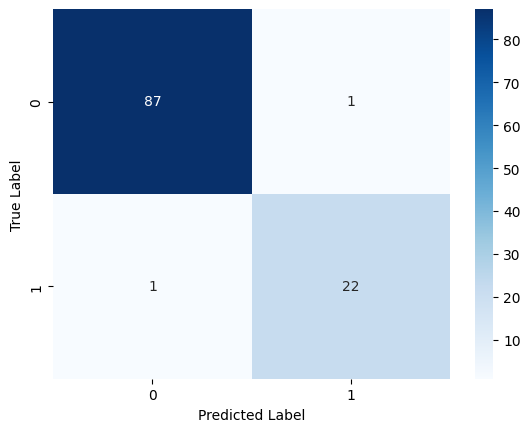

In [19]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [23]:
import librosa
import numpy as np

# Load and extract features from new audio
new_audio_file = '/content/Case study clinical example_ Session with a client with Bipolar Disorder (fluctuations in mood) (1) (online-audio-converter.com).wav'

# Load the audio file using librosa.load()
new_audio_data, sr = librosa.load(new_audio_file) # Load the audio file

# Now pass the audio data to the feature extraction function
new_audio_features = extract_mfcc_features(new_audio_data, sr) # Pass the loaded audio data

# Predict the label for the new audio
new_audio_features = np.reshape(new_audio_features, (1, -1))
prediction = model.predict(new_audio_features)
predicted_label = np.argmax(prediction, axis=1)

print(f"Predicted Label: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label: 1
